# Simple Convolutional Q8 Classification -- 4/07/2017
Retrain 4/04 on GPU
<pre>
Epoch 170/500 -- batch gd, lr=0.001
20s - loss: 4969.9554 - custom_acc: 0.5266 - val_loss: 4921.0333 - val_custom_acc: 0.4716
<br>-----
Epoch 201 -- minibatch size=200, lr=0.001
6s - loss: 4949.5145 - custom_acc: 0.5794 - val_loss: 4992.8395 - val_custom_acc: 0.4400

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras import optimizers
from keras import regularizers


import cullpdb_loader

Using TensorFlow backend.


## Constants and Hyperparameters
Declare constants about data such as the length of a protein and the number of possible residues and classes.
<br><br>
Declare hyperparameters about model such as learning rate, number of epochs of training (how many iterations through the entire data set to train for), etc.

In [2]:
NUM_RESIDUES = 700           # per protein
RESIDUE_SIZE = 22   
NUM_CLASSES = 9              # 8 + 'NoSeq'
PSSM_SIZE = 22
NUM_FEATURES = RESIDUE_SIZE  # size of one hot vector per residue

PSSM = False
if PSSM:
    NUM_FEATURES += PSSM_SIZE

FILTERS = 10       # Dimensions output by conv layer
WINDOW_SIZE = 11  # "scope" of convolution (ie 11 total residues)

TWO_D = True
if TWO_D:
    INPUT_SHAPE = (NUM_RESIDUES, NUM_FEATURES)  # see below
else:
    INPUT_SHAPE = (NUM_RESIDUES * NUM_FEATURES,)
OUTPUT_SIZE = NUM_CLASSES*NUM_RESIDUES      # output matrix holding predictions

LEARNING_RATE = 0.001
# regularization factor
L2 = 0.1
EPOCHS = 150  # iterations of training, total dataset covered once each epoch
MINIBATCH = 200
LOSS='categorical_crossentropy'
OPTIMIZER = optimizers.RMSprop(lr=LEARNING_RATE)

SHOW_ACCURACY = True  # set to False for quicker train ops

SAVE_FILE = "models/conv-filtered-4-07.h5py"
DATA = "data/cullpdb+profile_6133.npy.gz"
DATA_FILTERED = "data/cullpdb+profile_6133_filtered.npy.gz"
DATA_TEST = "data/cb513+profile_split1.npy.gz"

## Load Data
<b>Data:</b><br> _x represents input proteins, _y represents target structure classifications (each as one-hot vectors) <br><br>
<b>Data Shape:</b><br> First dimension represents number of proteins, second number of residues per protein, and third size of residue or structure vector.<br> For example, train_x without pssm is shape (5600, 700, 22): it is an <b>m \* n \* p</b> matrix where there are <b>m</b> proteins (each row), <b>n</b> residues per protein (each column), and <b>p</b> sized vectors to represent a single residue or a single structure (each "slice").

In [3]:
train = cullpdb_loader.load_residues(DATA_FILTERED, split=False, two_d=TWO_D, pssm=PSSM)  # load from my helper file

test = cullpdb_loader.load_cb513(DATA_TEST, two_d=TWO_D, pssm=PSSM)

# train, validation, and test were loaded as tuples of (input, output);
# here we unpack them into separate variables:
train_x, train_y = train
test_x, test_y = test

Loading protein residues and labels...
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cullpdb+profile_6133_filtered.npy.gz...
File Loaded.
Loaded protein residues and labels.
Reshaping...
Reshaped
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cb513+profile_split1.npy.gz...
File Loaded.


In [ ]:
# print a protein to see example representation (with character labels instead of one-hot vectors)
cullpdb_loader.print_residues(train_x[0], labels=train_y[0], two_d=TWO_D)

# print to verify data was loaded in correct shapes:
print("train_x:", train_x.shape)
print("train_y", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

### Custom Accuracy Metric

The default Keras accuracy metric does not compare observations and targets over multiple dimensions. A custom method to find  accuracy must be defined.
<br><br>
Here, a <b>mask</b> is created -- a matrix with ones where the target labels have labels that are not 'NoSeq', and zeros where the target labels are 'NoSeq'. We can then do a comparison between observed and target labels, and by multiplying the resulting boolean matrix by this mask, we ignore any right/wrong labels in the trailing 'NoSeq' region (that exists only to pad the protein to the correct length).
<br><br>
This gives an accuracy metric depending only on the non-'NoSeq' labels.

In [4]:
# Second custom accuracy: ignore trailing noseq's
def custom_acc(true, obs):
    print("Using custom accuracy")
    if not SHOW_ACCURACY:
        return K.constant(float('NaN'))
    
    # -1 = placeholder for whatever's left
    obs = K.reshape(obs, [-1, 700, 9])
    true = K.reshape(true, [-1, 700, 9])
    
    # convert one-hot vectors for residues to scalars
    true_vals = K.argmax(true, axis=2)
    obs_vals = K.argmax(obs, axis=2)
    
    # mask is 2D matrix with 1s in indices that are residues
    # and 0s in indices that are 'NoSeq'
    # subtract all 8's to shift 'NoSeq' values to zero
    mask = K.sign(K.abs(true_vals - 8*K.ones_like(true_vals, dtype='int64')))
    mask = K.cast(mask, dtype=K.floatx())
    # 1D vector with each index the number of non-'NoSeq' residues 
    # in corresponding protein
    length = K.sum(mask, axis=1)
    
    # compare observed and predicted values (cast from boolean to 1s and 0s),
    # then multiply by mask to nullify any trailing 'NoSeq' equalities
    comparison = K.cast(K.equal(true_vals, obs_vals), dtype=K.floatx())
    comparison = comparison * mask
    
    # and return average
    return K.sum(comparison) / K.sum(length)

## Model Architecture
The model is constructed to currently have 3 convolutional layers.<br><br>
A convolutional window "slides" across the input, each time taking the nearest <i>WINDOW_SIZE</i> number of features (residues) as inputs and outputing a single vector of dimension <i>FILTERS</i>. It performs this operation similarly to a usual perceptron, with a weight matrix and a gate function/nonlinearity.
<br><br>
This 3d data (samples, Protein Length, <i>FILTERS</i>) is flattened to 2d (samples, Length \* <i>FILTERS</i>). Finally a "dense", fully connected layer (A vanilla neural network/multiperceptron layer) reduces the dimensionality of the data from the previous <i>FILTERS</i> dimensions to <i>OUTPUT_SIZE</i> dimensions (here 9, 8 for each secondary structure class and 1 for None).

In [5]:
model = Sequential()

# border_mode indicates how the convolution handles the edges of the input (where the window "sticks out").
# The 'same' setting pads the inputs with zeros on either side.
# Only the first layer requires an input_shape parameter; successive layers infer it from within the model.

# 1st layer
model.add(Conv1D(
        FILTERS, WINDOW_SIZE, activation='tanh', padding='same', 
        kernel_regularizer=regularizers.l2(L2), input_shape=INPUT_SHAPE))
# 2nd layer
model.add(Conv1D(
        FILTERS, WINDOW_SIZE, activation='tanh', padding='same',
        kernel_regularizer=regularizers.l2(L2)))
# 3rd layer
model.add(Conv1D(
        FILTERS, WINDOW_SIZE, activation='tanh', padding='same',
        kernel_regularizer=regularizers.l2(L2)))
# 4th layer
#model.add(Conv1D(
#        FILTERS, WINDOW_SIZE, activation='tanh', padding='same'))
# 5th layer
#model.add(Conv1D(
#        FILTERS, WINDOW_SIZE, activation='tanh', padding='same'))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, name="OutputLayer", activation='softmax',
        kernel_regularizer=regularizers.l2(L2)))
#model.add(Reshape((NUM_RESIDUES, NUM_CLASSES)))

### Compile the model given a loss function, optimizer, and learning rate (specified above)

In [6]:
# optimizer= takes either string or optimizer object
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[custom_acc])

Using custom accuracy


### Train the model on training data against target training labels, show accuracy on validation data each epoch
Here, the <b>val_loss</b> and <b>val_acc</b> are the loss and accuracy on the test data. The loss is output by the cost function and has no absolute meaning by value, but relative values are important: we want them to decrease.

In [10]:
# Reshape the labels into a 2D matrix to make accuracy checks easier later on
train_y = train_y.reshape(len(train_y), NUM_CLASSES*NUM_RESIDUES)
test_y = test_y.reshape(len(test_y), NUM_CLASSES*NUM_RESIDUES)

# Training
# verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
hist = model.fit(train_x, train_y, epochs=EPOCHS, shuffle=True, verbose=2,
                 batch_size=MINIBATCH, validation_data=(test_x, test_y))
print("Done training")

Train on 5534 samples, validate on 514 samples
Epoch 1/150
6s - loss: 4953.2892 - custom_acc: 0.5700 - val_loss: 5007.4968 - val_custom_acc: 0.4195
Epoch 2/150
6s - loss: 4959.4647 - custom_acc: 0.5681 - val_loss: 4937.7865 - val_custom_acc: 0.4363
Epoch 3/150
6s - loss: 4950.7514 - custom_acc: 0.5708 - val_loss: 4934.0049 - val_custom_acc: 0.4366
Epoch 4/150
6s - loss: 4954.3521 - custom_acc: 0.5688 - val_loss: 4933.2333 - val_custom_acc: 0.4335
Epoch 5/150
6s - loss: 4953.9234 - custom_acc: 0.5693 - val_loss: 4938.4279 - val_custom_acc: 0.4351
Epoch 6/150
6s - loss: 4953.7792 - custom_acc: 0.5706 - val_loss: 4939.0685 - val_custom_acc: 0.4374
Epoch 7/150
6s - loss: 4952.0962 - custom_acc: 0.5726 - val_loss: 4942.7469 - val_custom_acc: 0.4357
Epoch 8/150
6s - loss: 4953.5500 - custom_acc: 0.5719 - val_loss: 4946.8206 - val_custom_acc: 0.4286
Epoch 9/150
6s - loss: 4953.8584 - custom_acc: 0.5716 - val_loss: 4948.1198 - val_custom_acc: 0.4382
Epoch 10/150
6s - loss: 4956.6381 - custom_a

KeyboardInterrupt: 

In [11]:
# Reshape labels back to original shape
train_y = train_y.reshape(-1, NUM_RESIDUES, NUM_CLASSES)
test_y = test_y.reshape(-1, NUM_RESIDUES, NUM_CLASSES)

In [12]:
model.save(SAVE_FILE)

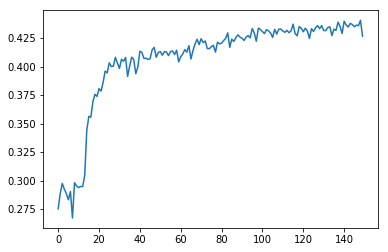

In [9]:
vali_loss = list(hist.history.values())[0]
plt.plot(range(EPOCHS), vali_loss)

## Test on cb513

In [ ]:
from keras.models import load_model
model = load_model(SAVE_FILE)

In [ ]:
test_acc = model.evaluate(test_x, test_y)
print(test_acc)

In [ ]:
i = 1
prediction = model.predict(test_x[i:i+1])
print("Shape:", prediction.shape)

In [ ]:
print("Expected:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=test_y[i], two_d=TWO_D)
print("\nPredicted:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=prediction[0], two_d=TWO_D)